In [1]:
%load_ext autoreload
%autoreload 2

curr_dir = '/user_data/vayzenbe/GitHub_Repos/goodale-milner-dnns'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys


sys.path.append('DeepDive')
sys.path.append('CORnet')
from deepdive.feature_extraction import get_empty_feature_maps, StimulusSet, get_all_feature_maps



import cornet

import torch

import torch.nn as nn
import torchvision
from torchvision.models import resnet18, alexnet, vgg19, vgg11


from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import svm

import warnings

from tqdm import tqdm
import itertools
warnings.filterwarnings('ignore')
import pdb


/home/vayzenbe/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_suf = ''

splits = 20


transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
#                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
            ])

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']

In [3]:
def load_model(model_arch):   
    if model_arch =='cornet_z':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='cornet_s':
        model = cornet.get_model('s', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='alexnet':
        model = alexnet(pretrained=True)

    elif model_arch =='vgg19':
        model = vgg19(pretrained=True)

    elif model_arch =='resnet18':
        model = resnet18(pretrained=True)
        
    return model

In [4]:
def get_loader(stim_dir):
    test_dataset =torchvision.datasets.ImageFolder(stim_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 2, pin_memory=True)
    return testloader, test_dataset


In [5]:
def plot_all_models(model_df,exp_name,file_suf=''):

    model_df['model layer'] = [f'{model}        {layer}' for model, layer in zip(model_df['model'], model_df['layer'])]
    fig = plt.figure(figsize=(25,5))
    ax = sns.barplot(data = model_df, x='model layer', hue='model', y='accuracy',dodge=False )
    ax.axhline(y=0.5, color='r', linestyle='--')
    plt.ylim(0, 1.1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #set yaxis interval to .25
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
    plt.legend().remove()
    #increase font size of y axis labels
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
    #change y axis title to accuracy
    ax.set_ylabel('Accuracy', fontsize=16)

    plt.title(exp_name, fontsize = 16)
    
    #     plt.tight_layout()
    plt.savefig(f'figures/models_{exp_name}_acc{file_suf}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression
def get_label_match_mat(labels):
    label_mat = np.zeros((len(labels), len(labels)), dtype=bool)
    for ii, label1 in enumerate(labels):
        for jj, label2 in enumerate(labels):
            label_mat[ii,jj] = label1 == label2
    return label_mat

def prep_similarities(X, y):
    sims = np.corrcoef(X)
    trili = np.tril_indices(sims.shape[0], k=-1)
    label_mat = get_label_match_mat(y)
    samediff = label_mat[trili]
    return sims[trili], samediff

def similarity_based_2way_classify(acts, labels, splits=3):
    acc = []
    for label_pair in itertools.combinations(np.unique(labels), 2):
        sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.33)
        inds = np.argwhere([label in label_pair for label in labels]).squeeze()
        acts_ = acts[inds]
        labels_ = labels[inds]
        sim, samediff = prep_similarities(acts_, labels_)
        for i, (train_index, test_index) in enumerate(sss.split(sim, samediff)):
            X_train, X_test = sim[train_index], sim[test_index]
            y_train, y_test = samediff[train_index], samediff[test_index]
            
            clf = LogisticRegression(penalty='none')
            clf.fit(X_train.reshape(-1,1), y_train)
            this_acc = clf.score(X_test.reshape(-1,1), y_test)
            acc.append(this_acc)

    return np.array(acc)

In [7]:
def paired_similarity(acts, labels):
    acc = []
    sames = []
    diffs = []
    for label_pair in itertools.combinations(np.unique(labels), 2):
        sss = StratifiedShuffleSplit(n_splits=splits, test_size=4)
        #run classifier
    #         these_accs = []
        inds = np.argwhere([label in label_pair for label in labels])
        #convert inds to list
        inds = inds.squeeze().tolist()
            
        acts_ = acts[inds]
        labels_ = labels[inds]

        sims_vec, samediff = prep_similarities(acts_, labels_)
        

        for i, (train_index, test_index) in enumerate(sss.split(sims_vec, samediff)):
            test_corrs = sims_vec[test_index]
            test_labels = samediff[test_index]
           
        
            same_corr = np.mean(test_corrs[test_labels == True])
            diff_corr = np.mean(test_corrs[test_labels == False])

            if same_corr > diff_corr:
                acc.append(1)
            elif same_corr == diff_corr:
                acc.append(.5)
            else:
                acc.append(0)
           

    return acc
        

100%|██████████| 5/5 [00:34<00:00,  6.83s/it]


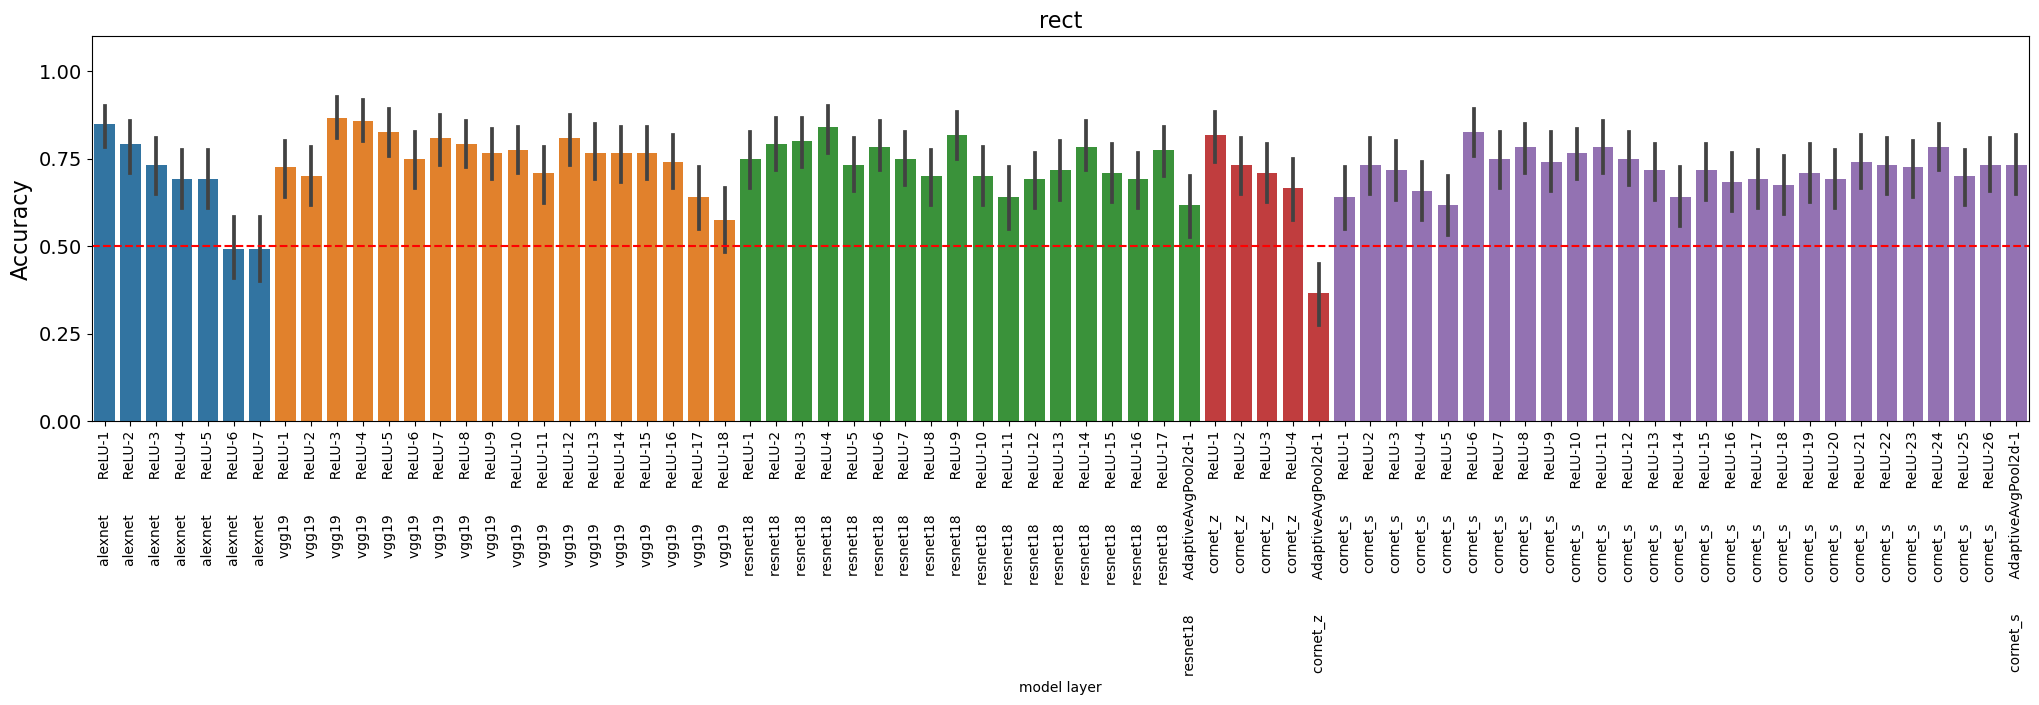

100%|██████████| 5/5 [00:47<00:00,  9.53s/it]


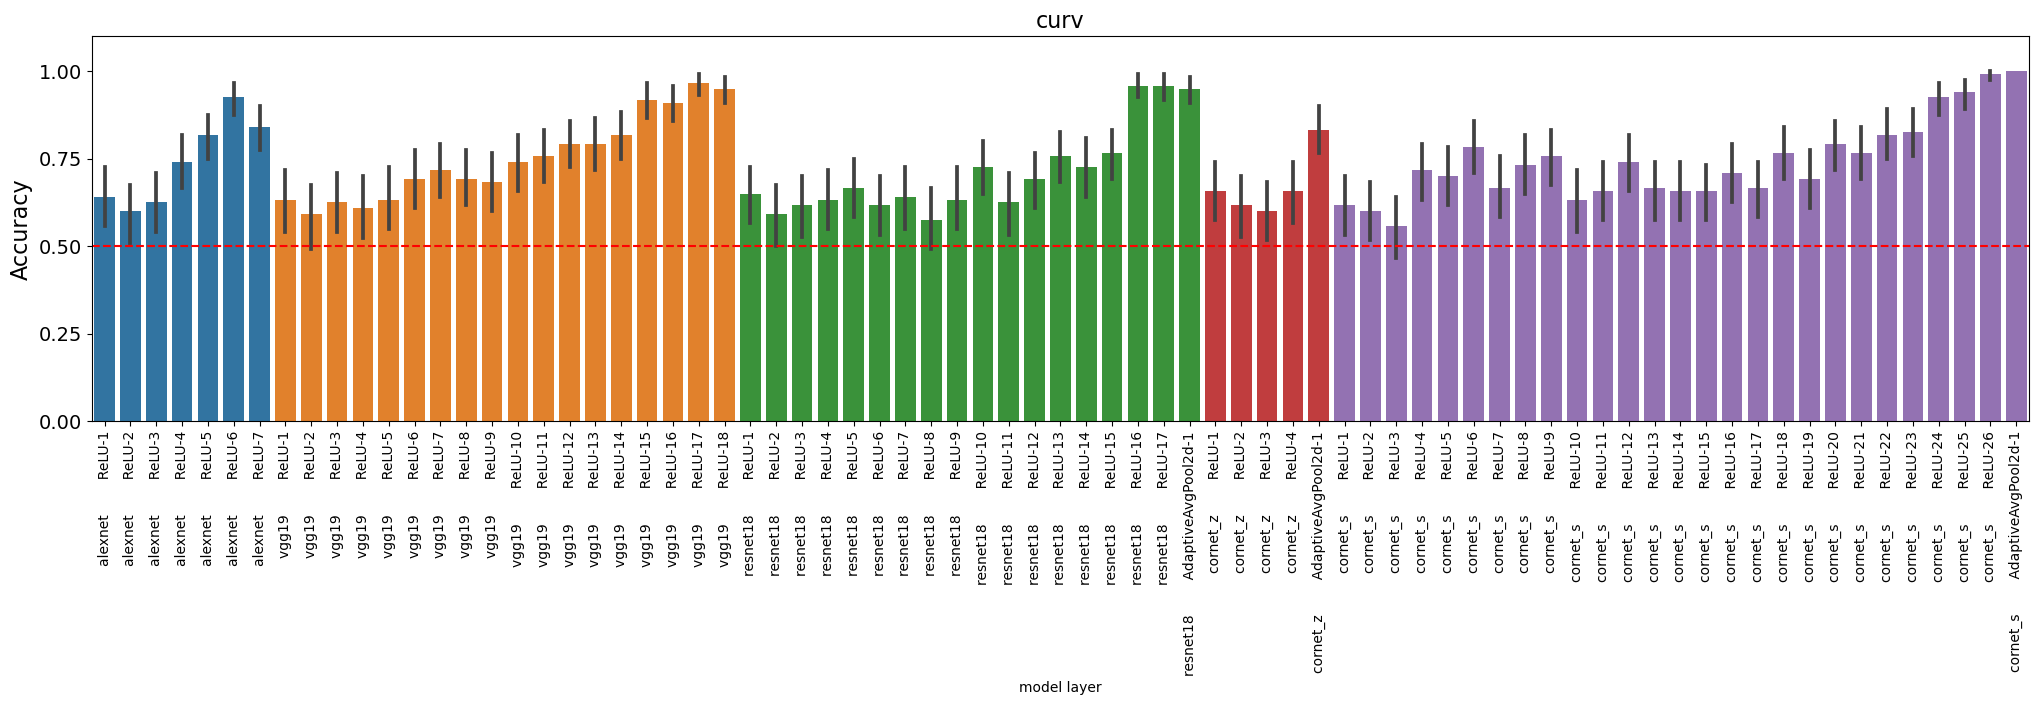

In [8]:
# get correlation distnace between same/different

condition = 'rot'
for experiment, exp_name in zip(['rect', 'curv'], ['Rectilinear', 'Curvilinear']):
    
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}_{condition}')

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            
            accs = paired_similarity(activations[layer], labels)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)
        
    model_df = pd.DataFrame(model_df)
    #model_df.to_csv(f'{curr_dir}/results/{exp_name}_acc_{condition}.csv')
    

    plot_all_models(model_df,experiment)

    

In [10]:
# get correlation distnace between same/different

condition = 'scale'
for experiment, exp_name in zip(['rect', 'curv'], ['Rectilinear', 'Curvilinear']):
    
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}_{condition}')

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            
            accs = paired_similarity(activations[layer], labels)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)
        
    model_df = pd.DataFrame(model_df)
    #model_df.to_csv(f'{curr_dir}/results/{exp_name}_acc_{condition}.csv')
    

    plot_all_models(model_df,experiment)

    

  0%|          | 0/5 [00:02<?, ?it/s]


ValueError: too many values to unpack (expected 3)

In [ ]:
# get RSA d-prime between same/different

model_df = dict(model=[], layer=[], accuracy=[], experiment=[])
for experiment in ['rect_scale', 'curv_scale']:
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}')
    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    # model_df = pd.DataFrame(columns = models)
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

        for layer in layers:
            accs = similarity_based_2way_classify(activations[layer], labels)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)
                model_df['experiment'].append(experiment)